## Prepare Data
Download and extract the zip file, then follow the tutorial to use Label Studio to label the data.

In [1]:
!wget https://docs.primehub.io/docs/assets/app_tutorial_labelstudio_screw_dataset.zip

--2021-08-02 09:37:24--  https://docs.primehub.io/docs/assets/app_tutorial_labelstudio_screw_dataset.zip
Resolving docs.primehub.io (docs.primehub.io)... 185.199.111.153, 185.199.110.153, 185.199.109.153, ...
Connecting to docs.primehub.io (docs.primehub.io)|185.199.111.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16099327 (15M) [application/zip]
Saving to: ‘app_tutorial_labelstudio_screw_dataset.zip’

app_tutorial_labels 100%[===================>]  15.35M  38.8MB/s    in 0.4s    

2021-08-02 09:37:25 (38.8 MB/s) - ‘app_tutorial_labelstudio_screw_dataset.zip’ saved [16099327/16099327]



In [2]:
!unzip -o app_tutorial_labelstudio_screw_dataset.zip -d screw-unlabeled
!rm app_tutorial_labelstudio_screw_dataset.zip

Archive:  app_tutorial_labelstudio_screw_dataset.zip
  inflating: screw-unlabeled/039.png  
  inflating: screw-unlabeled/000.png  
  inflating: screw-unlabeled/001.png  
  inflating: screw-unlabeled/002.png  
  inflating: screw-unlabeled/003.png  
  inflating: screw-unlabeled/004.png  
  inflating: screw-unlabeled/005.png  
  inflating: screw-unlabeled/006.png  
  inflating: screw-unlabeled/007.png  
  inflating: screw-unlabeled/008.png  
  inflating: screw-unlabeled/009.png  
  inflating: screw-unlabeled/010.png  
  inflating: screw-unlabeled/011.png  
  inflating: screw-unlabeled/012.png  
  inflating: screw-unlabeled/013.png  
  inflating: screw-unlabeled/014.png  
  inflating: screw-unlabeled/015.png  
  inflating: screw-unlabeled/016.png  
  inflating: screw-unlabeled/017.png  
  inflating: screw-unlabeled/018.png  
  inflating: screw-unlabeled/019.png  
  inflating: screw-unlabeled/020.png  
  inflating: screw-unlabeled/021.png  
  inflating: screw-unlabeled/022.png  
  inflating

In [3]:
!mkdir -p screw-labeled

## Start Training
After labeled all the images, you can run the following cells to start training and log results to MLflow.

In [4]:
import json
import shutil
import os
from pathlib import Path

In [5]:
dir_path = './screw-labeled'
data_path = './data'
data_train_good_path = os.path.join(data_path, 'train', 'good')
data_train_bad_path = os.path.join(data_path, 'train', 'bad')
data_val_good_path = os.path.join(data_path, 'val', 'good')
data_val_bad_path = os.path.join(data_path, 'val', 'bad')

p = Path(dir_path).glob('**/*')
files = [x for x in p if x.is_file()]

shutil.rmtree(data_path, ignore_errors=True)
os.makedirs(data_train_good_path, exist_ok=True)
os.makedirs(data_train_bad_path, exist_ok=True)
os.makedirs(data_val_good_path, exist_ok=True)
os.makedirs(data_val_bad_path, exist_ok=True)

val_count = 4
val_good_count = 0
val_bad_count = 0

for file in files:
    f = open(file)
    data = json.load(f)
    file_path = '/' + data['task']['data']['image'].split('?d=')[-1]
    file_name = file_path.split('/')[-1]
    result = data['result'][0]['value']['choices'][0]
    if result == 'good':
        if val_good_count < val_count:
            shutil.copyfile(file_path, os.path.join(data_val_good_path, file_name))
            val_good_count = val_good_count + 1
        else:
            shutil.copyfile(file_path, os.path.join(data_train_good_path, file_name))
    else:
        if val_bad_count < val_count:
            shutil.copyfile(file_path, os.path.join(data_val_bad_path, file_name))
            val_bad_count = val_bad_count + 1
        else:
            shutil.copyfile(file_path, os.path.join(data_train_bad_path, file_name))
    f.close()
    
print('done')

done


In [6]:
!pip install tensorflow_hub

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.preprocessing import image_dataset_from_directory

import mlflow
mlflow.set_experiment("tutorial_screw_train")
mlflow.tensorflow.autolog()

In [8]:
PATH = './data'

In [9]:
train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'val')

In [10]:
BATCH_SIZE = 8
IMG_SIZE = (1024, 1024)

In [11]:
train_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

Found 32 files belonging to 2 classes.


In [12]:
validation_dataset = image_dataset_from_directory(validation_dir,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE)

Found 8 files belonging to 2 classes.


Show some cases of training examples.

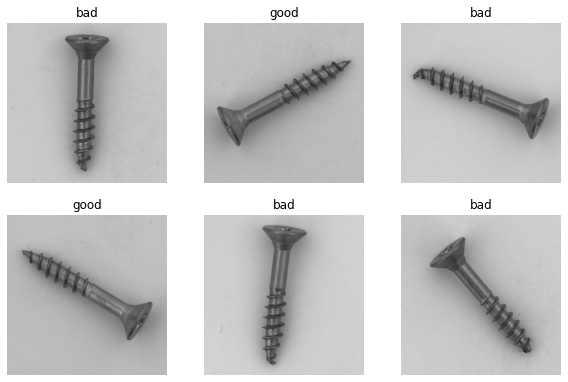

In [13]:
class_names = train_dataset.class_names

show_img = 1

if show_img:
    plt.figure(figsize=(10, 10))
    for images, labels in train_dataset.take(1):
        for i in range(6):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_names[labels[i]])
            plt.axis("off")

In [14]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip(),
])

In [15]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [16]:
model_url = "https://tfhub.dev/google/imagenet/mobilenet_v3_large_100_224/feature_vector/5"
base_model = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Resizing(224, 224),
    hub.KerasLayer(model_url, trainable=False)
])
base_model.build([None, 224, 224, 3])

In [17]:
base_model.trainable = False

In [18]:
prediction_layer = tf.keras.layers.Dense(1, kernel_regularizer=tf.keras.regularizers.l2(l2=0.1))

In [19]:
inputs = tf.keras.Input(shape=(1024, 1024, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [20]:
base_learning_rate = 0.01

In [21]:
model.compile(optimizer=tf.keras.optimizers.SGD(lr=base_learning_rate, momentum=0.9),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [22]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1024, 1024, 3)]   0         
_________________________________________________________________
sequential (Sequential)      (None, 1024, 1024, 3)     0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 1024, 1024, 3)     0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 1024, 1024, 3)     0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 1280)              4226432   
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 4,227,713
Trainable params: 1,281
Non-trainable params: 4,226,432
_______________________________________________

In [23]:
initial_epochs = 25

loss0, accuracy0 = model.evaluate(validation_dataset)

1/1 [==============================] - 2s 2s/step - loss: 1.0613 - accuracy: 0.5000


In [24]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 1.06
initial accuracy: 0.50


In [25]:
def scheduler(epoch, lr):
    if epoch >= 10 and epoch % 10 == 0:
        return lr / 5
    return lr
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [26]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset, callbacks=[callback])

2021/08/02 09:39:09 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'b51ef3155d5648628dfd6434ed26b410', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow


Epoch 1/25
4/4 [==============================] - 13s 2s/step - loss: 0.9742 - accuracy: 0.4062 - val_loss: 0.9837 - val_accuracy: 0.1250
Epoch 2/25
4/4 [==============================] - 7s 2s/step - loss: 0.8248 - accuracy: 0.5625 - val_loss: 0.8374 - val_accuracy: 0.5000
Epoch 3/25
4/4 [==============================] - 7s 2s/step - loss: 0.7271 - accuracy: 0.6250 - val_loss: 0.7079 - val_accuracy: 0.8750
Epoch 4/25
4/4 [==============================] - 7s 2s/step - loss: 0.4832 - accuracy: 0.9688 - val_loss: 0.7356 - val_accuracy: 0.7500
Epoch 5/25
4/4 [==============================] - 7s 2s/step - loss: 0.4496 - accuracy: 0.9688 - val_loss: 0.7756 - val_accuracy: 0.6250
Epoch 6/25
4/4 [==============================] - 7s 2s/step - loss: 0.4875 - accuracy: 0.9062 - val_loss: 0.6469 - val_accuracy: 0.8750
Epoch 7/25
4/4 [==============================] - 7s 2s/step - loss: 0.4817 - accuracy: 0.8750 - val_loss: 0.5902 - val_accuracy: 0.7500
Epoch 8/25
4/4 [========================

Using TensorFlow backend.


INFO:tensorflow:Assets written to: /tmp/tmpefz6xsdd/model/data/model/assets


INFO:tensorflow:Assets written to: /tmp/tmpefz6xsdd/model/data/model/assets


In [27]:
lossfinal, accuracyfinal = model.evaluate(validation_dataset)

1/1 [==============================] - 1s 770ms/step - loss: 0.5423 - accuracy: 0.8750


In [28]:
print("final loss: {:.2f}".format(lossfinal))
print("final accuracy: {:.2f}".format(accuracyfinal))

final loss: 0.54
final accuracy: 0.88
